# Activities Classification with Explainable AI (XAI)

<!-- ![title](Figure_2.png) -->

This notebook is of two main sections.
Section 1 - This section contains the code used for creating an FGSM based evasion attack. This dataset is later used to get the explanations for section 2.
Section 2 - Shows a comparison between the explanations of the evasion attack and the benign data.

In [1]:
!pip install adversarial-robustness-toolbox --quiet

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

#Stops any warning
import warnings
warnings.filterwarnings('ignore')

## Stop the INFO level logging from printing
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

c:\Users\thuli\anaconda3\envs\mi_xai\lib\site-packages\art\estimators\certification\__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


## Opening the files
Load the training/testing dataset from csv files
first column: ID
last column: the expected output, for example: 1, 2, 3, corresponds to one of 3 activities
+ 1: web browsing/file downloading
+ 2: online communication, like video call
+ 3: online video watching

In [3]:
# Load the training/testing dataset from csv files
training_dataset = pd.read_csv("../../output_train.csv", header=0, usecols=[*range(1,23)], sep=";")
testing_dataset = pd.read_csv("../../output_test.csv", header=0, usecols=[*range(1,23)], sep=";")

# Remove missing values
training_dataset.dropna(axis = 0, inplace = True)
testing_dataset.dropna(axis = 0, inplace = True)

print("The shape of the training dataset: " + str(training_dataset.shape))
print("The shape of the testing dataset: " + str(testing_dataset.shape))

training_dataset.head()

The shape of the training dataset: (279, 22)
The shape of the testing dataset: (103, 22)


,session_time,%tcp_protocol,%udp_protocol,ul_data_volume,max_ul_volume,min_ul_volume,avg_ul_volume,std_ul_volume,%ul_volume,dl_data_volume,...,avg_dl_volume,std_dl_volume,%dl_volume,nb_uplink_packet,nb_downlink_packet,ul_packet,dl_packet,kB/s,nb_packet/s,output
0,4.999674,100.000000,0.000000,99090,54,54,54.000000,0.000000,1.652834,5896066,...,1564.358185,313.304936,98.347166,1835,3769,32.744468,67.255532,1199.109362,1120.873063,1
1,0.892125,100.000000,0.000000,32184,54,54,54.000000,0.000000,1.673617,1890837,...,1594.297639,601.903863,98.326383,596,1186,33.445567,66.554433,2155.550758,1997.477642,1
2,3.412767,99.857265,0.142735,77133,471,54,55.213314,18.696881,2.276791,3310662,...,1571.268154,562.653689,97.723209,1397,2107,39.868721,60.131279,992.682790,1026.732873,1
3,4.999285,99.888471,0.111529,142985,471,54,54.699694,14.495354,1.925924,7281243,...,1597.114060,649.341567,98.074076,2614,4559,36.442214,63.557786,1485.057968,1434.805182,1
4,1.682172,100.000000,0.000000,60534,54,54,54.000000,0.000000,1.571208,3792170,...,1645.907118,1250.277675,98.428792,1121,2304,32.729927,67.270073,2290.315058,2036.058071,1


In [4]:
# Set of features in the dataset
_initial_cols = list(testing_dataset.columns)
print(_initial_cols[:-1])

['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [109]:
# Convert the expected output into arrays, e.g., 1 -> [1, 0, 0]
output_training = []
for i, val in enumerate(training_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_training.append(temp)

output_testing = []
for i, val in enumerate(testing_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_testing.append(temp)

# Remove the expected output column from the datasets
prep_training_dataset = training_dataset.drop(columns=['output'])
prep_testing_dataset = testing_dataset.drop(columns=['output'])

# Preprocessing the data
scaler = StandardScaler()
scaler.fit(prep_training_dataset)

# Apply transform to both the training/testing dataset.
X_train = scaler.transform(prep_training_dataset)
Y_train = np.array(output_training)

X_test = scaler.transform(prep_testing_dataset)
Y_test = np.array(output_testing)

# print("Preprocessed inputs of the training dataset: " + str(X_train))
# print("Preprocessed outputs of the training dataset: " + str(Y_train))

In [115]:
features = prep_testing_dataset.columns

# Section 1 - Evasion Attack

## Neural Network Model

In [ ]:
# Define the Keras model
model = Sequential()
model.add(Dense(12, input_shape=(21,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

# Compile the Keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Put the classifier into ART wrapper
model = KerasClassifier(model=model, use_logits=False)

# Fit the Keras model on the dataset
model.fit(X_train, Y_train, nb_epochs=150, batch_size=10)

# Evaluate the Keras model
# _, accuracy = model.evaluate(X_train, Y_train)
# print('Accuracy: %.2f' % (accuracy*100))

NN_model = model

predictions = model.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(Y_test, axis=1)) / len(Y_test)
print("Accuracy on normal test examples: {}%".format(accuracy * 100))

### Generate Evasion attack dataset

In [77]:
# Generate adversarial test examples
def generate_evasion_data():
    attack = FastGradientMethod(estimator=model, eps=0.4)
    x_test_adv = attack.generate(x=X_test, verbose=2)
    return attack, x_test_adv
# attack, x_test_adv = generate_evasion_data()

In [78]:
attack, x_test_adv = generate_evasion_data()
print(f"Length of evasion dataset: {len(x_test_adv)}")

predictions = model.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(Y_test, axis=1)) / len(Y_test)
print(f"Accuracy on adversarial test examples: {accuracy * 100:.2f}%")

Length of evasion dataset: 103
Accuracy on adversarial test examples: 59.22%


### Model Confusion Matrix

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


Wrong prediction at sample 61
Prediction: [0 0 1] but expected output: [0 1 0]
Wrong prediction at sample 71
Prediction: [1 0 0] but expected output: [0 0 1]
Wrong prediction at sample 81
Prediction: [1 0 1] but expected output: [0 0 1]
Wrong prediction at sample 83
Prediction: [1 0 0] but expected output: [0 0 1]
Confusion matrix: 
[[80  0  0]
 [ 0  6  1]
 [ 3  0 13]]
Number of wrong predictions: 4
Accuracy: 96.11650485436893%


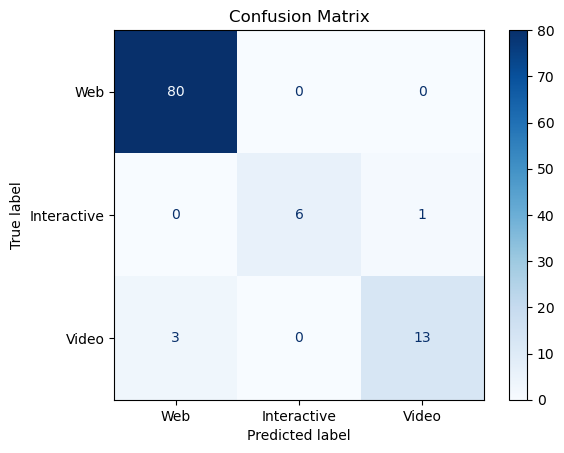

In [80]:

# Make class predictions with the model
predictions = (model.predict(X_test) > 0.5).astype(int)

nb_errors = 0
nb_tests = len(X_test)
errors = []
for i in range(0,len(X_test)):
	#print('%s (expected %s)' % (predictions[i].tolist(), Y_test[i].tolist()))
	if (predictions[i].tolist() != Y_test[i].tolist()):
		errors.append(i)
		nb_errors += 1

accuracy = (nb_tests - nb_errors) * 100 / nb_tests

for i in errors:
	print("Wrong prediction at sample " + str(i + 1))
	#print(X_test[i])
	print("Prediction: " + str(predictions[i]) + " but expected output: " + str(Y_test[i]))

Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print("Confusion matrix: \n" + str(cm))

labels = ["Web", "Interactive", "Video"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print("Number of wrong predictions: " + str(nb_errors))
print("Accuracy: " + str(accuracy) + "%")

## LightGBM 

r_2 score: 0.733253
mean_squared_log_error score: 0.016404
Wrong predictions: [56, 57, 60, 70, 80, 82]
Confusion matrix: 
[[80  0  0]
 [ 0  4  3]
 [ 3  0 13]]


Text(0.5, 1.0, 'Confusion Matrix of LightGBM')

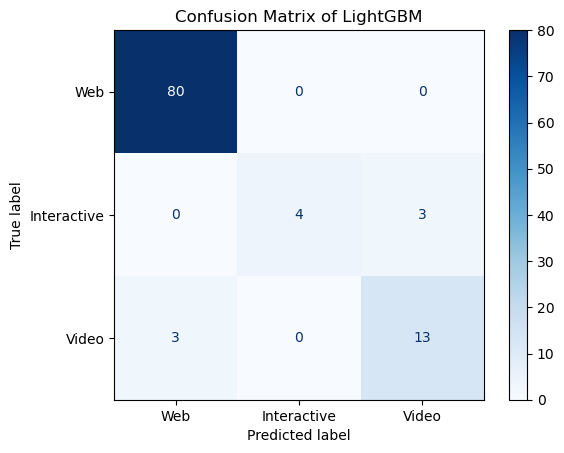

In [142]:
import lightgbm as ltb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = ltb.LGBMClassifier()
# Using Y_train here got an error of shape
model.fit(X_train, training_dataset.iloc[:,21])

lgbm_model = model
    
Y_expected = testing_dataset.iloc[:,21]
Y_predicted = model.predict(X_test)

r_2_score = metrics.r2_score(Y_expected, Y_predicted)
mean_squared_log_error_score = metrics.mean_squared_log_error(Y_expected, Y_predicted)
print("r_2 score: %f" % (r_2_score))
print("mean_squared_log_error score: %f" % (mean_squared_log_error_score))

wrong_preds = []
for i in range(len(Y_expected)):
    if Y_predicted[i] != Y_expected[i]:
        wrong_preds.append(i)

print("Wrong predictions: " + str(wrong_preds))

cm = confusion_matrix(Y_expected, Y_predicted)
print("Confusion matrix: \n" + str(cm))

labels = ["Web", "Interactive", "Video"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix of LightGBM")

In [82]:
predictions = model.predict(X_test)
accuracy = metrics.accuracy_score(Y_expected, predictions)
print("Accuracy on normal test examples: {}%".format(accuracy * 100))

Accuracy on normal test examples: 94.1747572815534%


In [83]:
predictions = model.predict(x_test_adv)
accuracy = metrics.accuracy_score(Y_expected, predictions)
print("Accuracy on normal test examples: {}%".format(accuracy * 100))

Accuracy on normal test examples: 65.0485436893204%


### Model Confusion Matrix

Wrong prediction at sample 57
Prediction: 1 but expected output: 2
Wrong prediction at sample 58
Prediction: 1 but expected output: 2
Wrong prediction at sample 59
Prediction: 1 but expected output: 2
Wrong prediction at sample 60
Prediction: 1 but expected output: 2
Wrong prediction at sample 61
Prediction: 1 but expected output: 2
Wrong prediction at sample 62
Prediction: 1 but expected output: 2
Wrong prediction at sample 63
Prediction: 1 but expected output: 2
Wrong prediction at sample 67
Prediction: 1 but expected output: 3
Wrong prediction at sample 68
Prediction: 1 but expected output: 3
Wrong prediction at sample 69
Prediction: 1 but expected output: 3
Wrong prediction at sample 70
Prediction: 1 but expected output: 3
Wrong prediction at sample 71
Prediction: 1 but expected output: 3
Wrong prediction at sample 74
Prediction: 1 but expected output: 3
Wrong prediction at sample 75
Prediction: 1 but expected output: 3
Wrong prediction at sample 76
Prediction: 1 but expected outpu

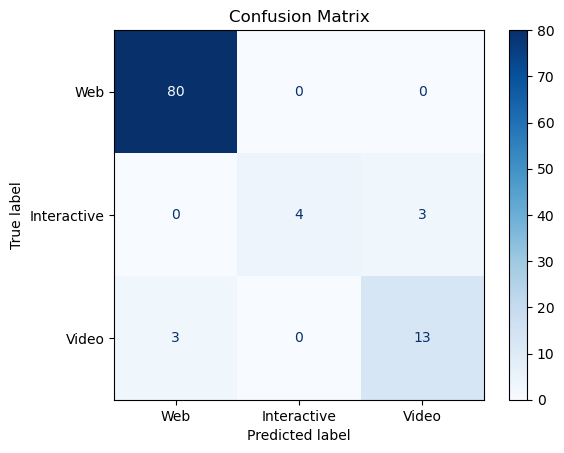

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Make class predictions with the model
predictions = (model.predict(X_test) > 0.5).astype(int)

nb_errors = 0
nb_tests = len(X_test)
errors = []
for i in range(0,len(X_test)):
	#print('%s (expected %s)' % (predictions[i].tolist(), Y_test[i].tolist()))
	if (predictions[i].tolist() != Y_expected[i].tolist()):
		errors.append(i)
		nb_errors += 1

accuracy = (nb_tests - nb_errors) * 100 / nb_tests

for i in errors:
	print("Wrong prediction at sample " + str(i + 1))
	#print(X_test[i])
	print("Prediction: " + str(predictions[i]) + " but expected output: " + str(Y_expected[i]))

Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_expected, Y_pred)
print("Confusion matrix: \n" + str(cm))

labels = ["Web", "Interactive", "Video"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print("Number of wrong predictions: " + str(nb_errors))
print("Accuracy: " + str(accuracy) + "%")

## XGBoost

In [85]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [86]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
print(xgbc)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 
xgbc.fit(X_train, training_dataset.iloc[:,21])

model = xgbc

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[19:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[19:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

Text(0.5, 1.0, 'Confusion Matrix of XGBoost')

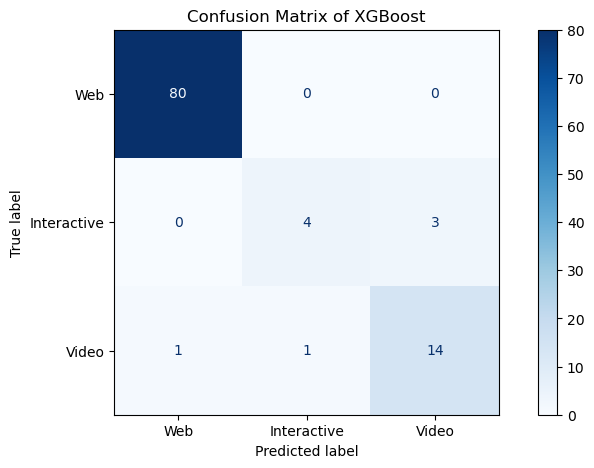

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

scores = cross_val_score(xgbc, X_train, training_dataset.iloc[:,21], cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, training_dataset.iloc[:,21], cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

# make sure the SHAP values add up to marginal predictions
Y_pred = xgbc.predict(X_test, output_margin=True)
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print("Confusion matrix: \n" + str(cm))

labels = ["Web", "Interactive", "Video"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax)
disp.ax_.set_title("Confusion Matrix of XGBoost")

In [88]:
predictions = np.argmax(xgbc.predict(X_test, output_margin=True), axis=1)+1
accuracy = metrics.accuracy_score(Y_expected, predictions)
print("Accuracy on normal test examples: {}%".format(accuracy * 100))

Accuracy on normal test examples: 95.14563106796116%


In [89]:
predictions = np.argmax(xgbc.predict(x_test_adv, output_margin=True), axis=1)+1
accuracy = metrics.accuracy_score(Y_expected, predictions)
print("Accuracy on normal test examples: {}%".format(accuracy * 100))

Accuracy on normal test examples: 62.13592233009708%


### Model Confusion Matrix

Confusion matrix: 
[[80  0  0]
 [ 0  4  3]
 [ 1  1 14]]
Number of wrong predictions: 23
Accuracy: 77.66990291262135%


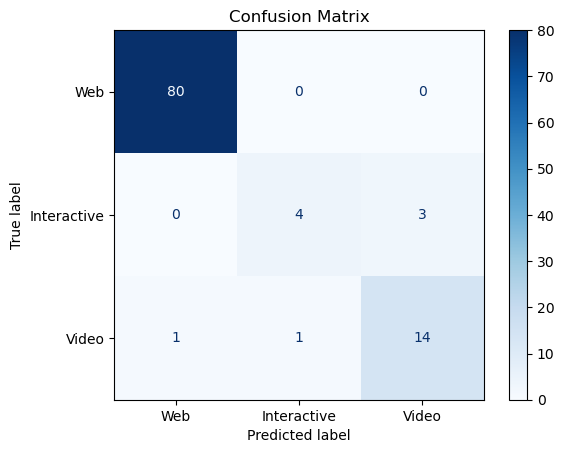

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# # Make class predictions with the model
# predictions = (model.predict(X_test)                      ).astype(int)

# nb_errors = 0
# nb_tests = len(X_test)
# errors = []
# for i in range(0,len(X_test)):
# 	#print('%s (expected %s)' % (predictions[i].tolist(), Y_test[i].tolist()))
# 	if (predictions[i].tolist() != Y_test[i].tolist()):
# 		errors.append(i)
# 		nb_errors += 1

# accuracy = (nb_tests - nb_errors) * 100 / nb_tests

# for i in errors:
# 	print("Wrong prediction at sample " + str(i + 1))
# 	#print(X_test[i])
# 	print("Prediction: " + str(predictions[i]) + " but expected output: " + str(Y_test[i]))

# Y_pred = model.predict(X_test)
# cm = confusion_matrix(Y_expected, Y_pred)
# print("Confusion matrix: \n" + str(cm))

# labels = ["Web", "Interactive", "Video"]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues)
# disp.ax_.set_title("Confusion Matrix")

# print("Number of wrong predictions: " + str(nb_errors))
# print("Accuracy: " + str(accuracy) + "%")

# Make class predictions with the model
predictions = (model.predict(X_test) > 0.5).astype(int)

nb_errors = 0
nb_tests = len(X_test)
errors = []
for i in range(0,len(X_test)):
	#print('%s (expected %s)' % (predictions[i].tolist(), Y_test[i].tolist()))
	if (predictions[i].tolist() != Y_expected[i].tolist()):
		errors.append(i)
		nb_errors += 1

accuracy = (nb_tests - nb_errors) * 100 / nb_tests

# for i in errors:
	# print("Wrong prediction at sample " + str(i + 1))
	#print(X_test[i])
	# print("Prediction: " + str(predictions[i]) + " but expected output: " + str(Y_expected[i]))

Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_expected, Y_pred)
print("Confusion matrix: \n" + str(cm))

labels = ["Web", "Interactive", "Video"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print("Number of wrong predictions: " + str(nb_errors))
print("Accuracy: " + str(accuracy) + "%")

# Section 2 - Consistency comparison (Benign vs Evasion)

In [277]:
import lime
import random
from tqdm import tqdm

from lime import lime_tabular
from matplotlib import pyplot as plt
from pydoc import classname
import warnings
import shap
import scipy as sp

from shapash.explainer.consistency import Consistency
from shapash import SmartExplainer

## Benign data

In [148]:
class model_wrapper:
    def __init__(self, model, col_oder):
        self.model = model
        self.col_oder = col_oder
    def predict_fn(self, x):
        if isinstance(self.model, XGBClassifier):
            return sp.special.softmax(self.model.predict(x, output_margin=True), axis=1)
        elif isinstance(self.model, KerasClassifier):
            return self.model.predict(x)
        else:
            return self.model.predict_proba(x)

In [267]:
def generate_shap_contributions(shap_explainer, test_dataset, model, label_to_use = 0):
    # input_array: one or multiple datapoints
    shap_values = shap_explainer.shap_values(test_dataset, check_additivity=False)
    # if isinstance(shap_explainer, shap.KernelExplainer):
    shap_df = pd.DataFrame(shap_values[label_to_use], columns=model.col_oder)
    # elif isinstance(shap_explainer, shap.SamplingExplainer):
    #     shap_df = pd.DataFrame(shap_values[label_to_use], columns=model.col_oder)
    return shap_df

def generate_lime_contributions(lime_explainer, model, test_dataset, num_samples, label_to_use = 0):
    # input_array: one or multiple datapoints
    explanations=[]
    exp_scores=[]
    for input_pnt in test_dataset:  
        exp = lime_explainer.explain_instance(
                                input_pnt
                                , model.predict_fn
                                , num_samples=num_samples
                                , distance_metric='euclidean'
                                , num_features=len(model.col_oder)
                                , top_labels=3)
        exp_values = exp.as_map()[label_to_use]
        exp_values.sort(key=lambda x: x[0])
        explanations.append(exp_values)
        exp_scores.append(exp.score)
    explanations, exp_score = np.asarray(explanations), np.asarray(exp_scores)
    explanations_df = pd.DataFrame(explanations[:,:,1], columns=model.col_oder)
    return explanations_df, exp_score

def fit_all_explainers(model, train_dataset, class_names):
    lime_explainer = lime_tabular.LimeTabularExplainer(
                train_dataset
                , mode="classification"
                , feature_names=model.col_oder
                , feature_selection= 'auto'
                , kernel_width=None
                , sample_around_instance=True
                , discretize_continuous=True
                , class_names=class_names)
    
    samplingSHAP_explainer = shap.SamplingExplainer(model.predict_fn
                        , shap.kmeans(train_dataset, 5))
    kernelSHAP_explainer = shap.KernelExplainer(model.predict_fn
                                    , shap.kmeans(train_dataset, 5))
    return lime_explainer, kernelSHAP_explainer, samplingSHAP_explainer


### Consistecy for LightGBM

In [282]:
model = model_wrapper(lgbm_model, features)

In [283]:
lime_explainer, kernelSHAP_explainer, samplingSHAP_explainer = fit_all_explainers(
                                          model, X_test
                                        , class_names=['Web', 'Interactive', 'Video'])

contrib_KernelSHAP = generate_shap_contributions(kernelSHAP_explainer, X_test
                                                , model)
contrib_SamplingSHAP = generate_shap_contributions(samplingSHAP_explainer, X_test
                                                   , model)
contrib_LIME, exp_scores = generate_lime_contributions(lime_explainer
                                                       , model, X_test
                                                       , num_samples = 2000
                                                       )

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

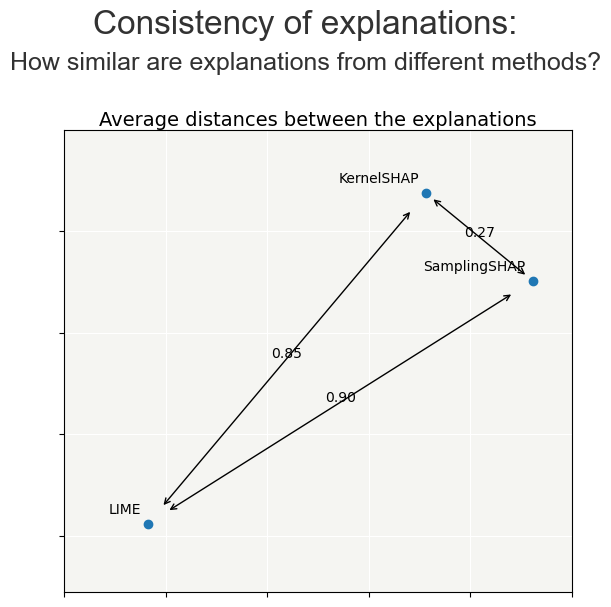

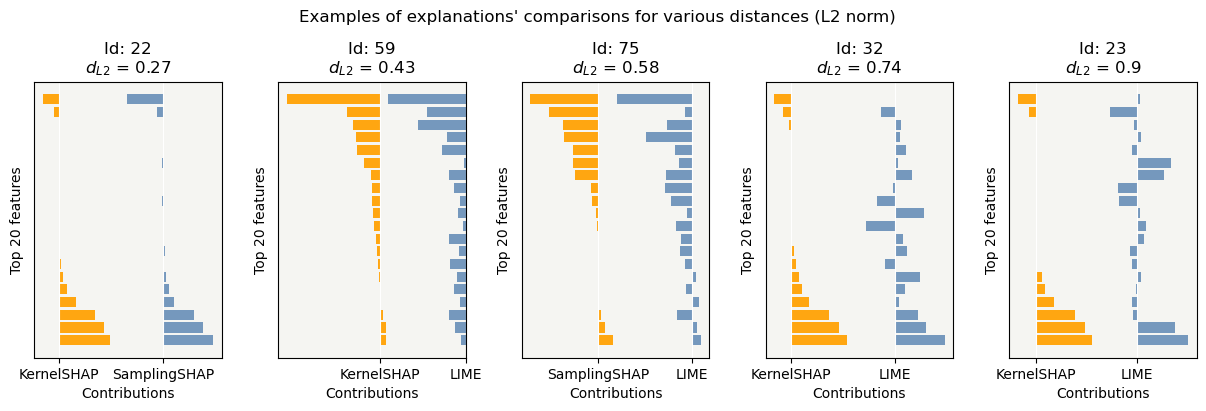

In [284]:
contributions_dict = {
    'KernelSHAP': contrib_KernelSHAP,
    'SamplingSHAP': contrib_SamplingSHAP,
    'LIME': contrib_LIME
}
cns = Consistency()
cns.compile(contributions=contributions_dict)
cns.consistency_plot()

### Consistency for XGBC

In [268]:
model = model_wrapper(xgbc, features)

In [269]:
lime_explainer, kernelSHAP_explainer, samplingSHAP_explainer = fit_all_explainers(
                                          model, X_test
                                        , class_names=['Web', 'Interactive', 'Video'])

contrib_KernelSHAP = generate_shap_contributions(kernelSHAP_explainer, X_test
                                                , model)
contrib_SamplingSHAP = generate_shap_contributions(samplingSHAP_explainer, X_test
                                                   , model)
contrib_LIME, exp_scores = generate_lime_contributions(lime_explainer
                                                       , model, X_test
                                                       , num_samples = 2000
                                                       )

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

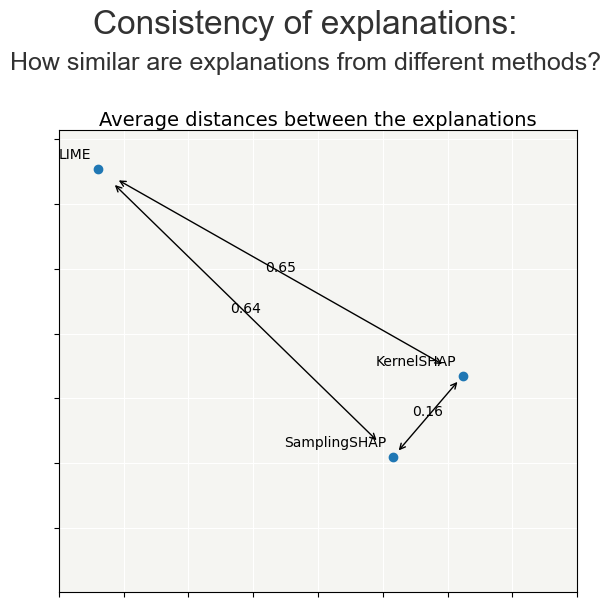

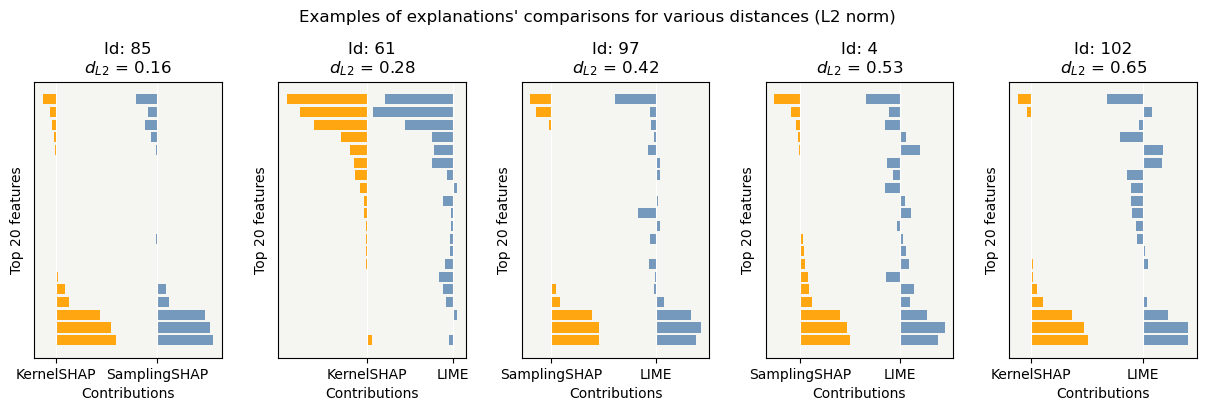

In [278]:
contributions_dict = {
    'KernelSHAP': contrib_KernelSHAP,
    'SamplingSHAP': contrib_SamplingSHAP,
    'LIME': contrib_LIME
}
cns = Consistency()
cns.compile(contributions=contributions_dict)
cns.consistency_plot()

## Attack data

### Consistency for XGBC

In [279]:
model = model_wrapper(xgbc, features)

In [280]:
lime_explainer, kernelSHAP_explainer, samplingSHAP_explainer = fit_all_explainers(
                                          model, X_test
                                        , class_names=['Web', 'Interactive', 'Video'])

contrib_KernelSHAP = generate_shap_contributions(kernelSHAP_explainer, x_test_adv
                                                , model)
contrib_SamplingSHAP = generate_shap_contributions(samplingSHAP_explainer, x_test_adv
                                                   , model)
contrib_LIME, exp_scores = generate_lime_contributions(lime_explainer
                                                       , model, x_test_adv
                                                       , num_samples = 2000
                                                       )

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

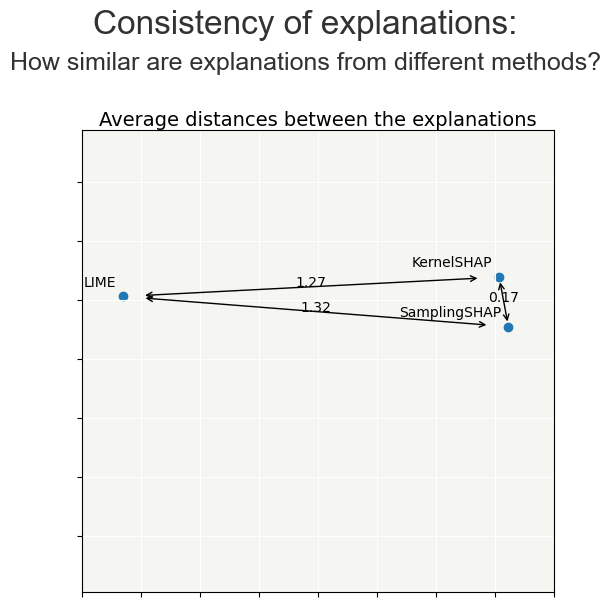

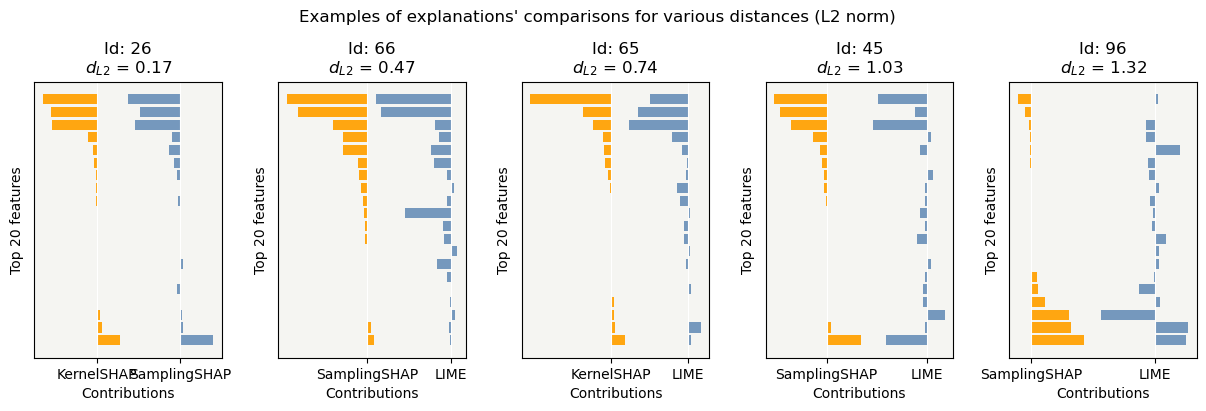

In [281]:
contributions_dict = {
    'KernelSHAP': contrib_KernelSHAP,
    'SamplingSHAP': contrib_SamplingSHAP,
    'LIME': contrib_LIME
}
cns = Consistency()
cns.compile(contributions=contributions_dict)
cns.consistency_plot()

### Consistency for LGBM

In [285]:
model = model_wrapper(lgbm_model, features)

In [286]:
lime_explainer, kernelSHAP_explainer, samplingSHAP_explainer = fit_all_explainers(
                                          model, X_test
                                        , class_names=['Web', 'Interactive', 'Video'])

contrib_KernelSHAP = generate_shap_contributions(kernelSHAP_explainer, x_test_adv
                                                , model)
contrib_SamplingSHAP = generate_shap_contributions(samplingSHAP_explainer, x_test_adv
                                                   , model)
contrib_LIME, exp_scores = generate_lime_contributions(lime_explainer
                                                       , model, x_test_adv
                                                       , num_samples = 2000
                                                       )

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

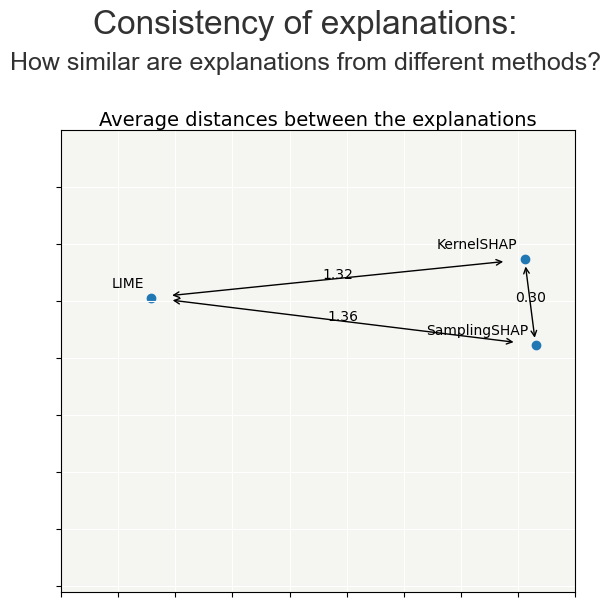

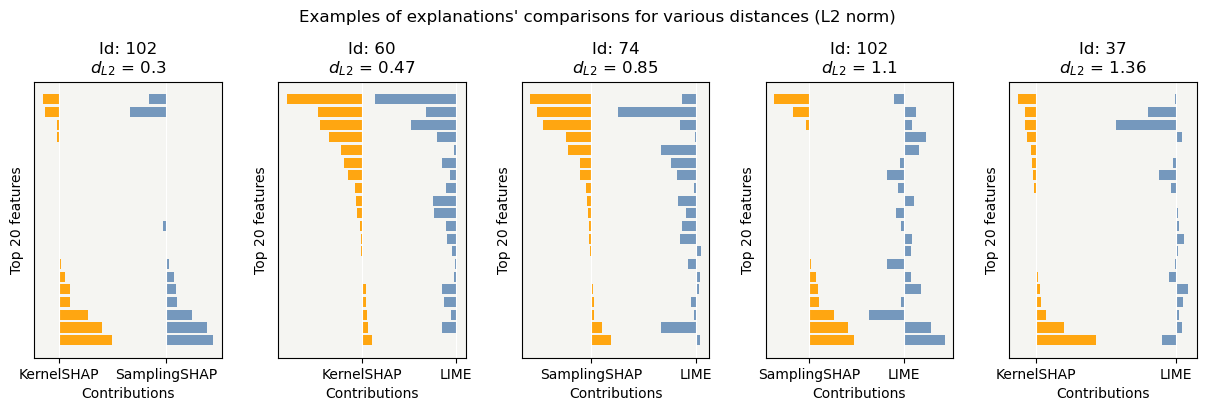

In [287]:
contributions_dict = {
    'KernelSHAP': contrib_KernelSHAP,
    'SamplingSHAP': contrib_SamplingSHAP,
    'LIME': contrib_LIME
}
cns = Consistency()
cns.compile(contributions=contributions_dict)
cns.consistency_plot()